# End to end bipartite graph generation demo (IEEE)

## Overview

In this notebook, we walk through the complete process of generating a synthetic dataset based on an IEEE dataset. The IEEE dataset includes information about e-commerce transactions, so it can be iterpreted as a bipartite graph (user / product) with edge features (transaction info).

Content:

1. [Fit synthesizer](#1)
1. [Dataset generation](#2)
1. [Tabular data evaluation](#3)
1. [Structure evaluation](#4)

### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets.ieee import IEEEPreprocessing

# generation
from syngen.synthesizer import StaticBipartiteGraphSynthesizer, StaticGraphSynthesizer
from syngen.graph_aligner.xgboost_aligner import XGBoostAligner
from syngen.graph_aligner.random_aligner import RandomAligner
from syngen.generator.tabular.gaussian_generator import GaussianGenerator
from syngen.generator.tabular.uniform_generator import UniformGenerator
from syngen.generator.tabular.ctgan import CTGANGenerator
from syngen.generator.graph import RMATBipartiteGenerator

# evaluation
from syngen.analyzer.tabular import TabularMetrics
from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.stats import get_dd_simmilarity_score
from syngen.analyzer.graph.analyser import AnalysisModule
from syngen.analyzer.graph.plotting import plot_node_degree_centrality_feat_dist

# utils
import cudf
import numpy as np
import pandas as pd  
from syngen.utils.types import MetaData, ColumnType

from matplotlib.pyplot import set_loglevel
set_loglevel('warning')

<a id="1"></a>
### Fit synthesizer

#### Instantiating the building blocks

As the IEEE dataset is a graph with edge features, and suppose we would like to similarly generate graph with edge features the following objects are instantiated

- A edge feature generator to generate the node features. In this example CTGAN is used.
- A graph generator to generate the graph structure. As the original graph is bipartite, the RMATBipartiteGenerator is used.
- An aligner to align the two.


**Note**: Alternative generators can be used as long as they implement the `fit` \& `generate` API and consumes data dictionary (described below).

In [2]:
edge_feature_generator = CTGANGenerator(epochs=10, batch_size=2000, verbose=False)
static_graph_generator = RMATBipartiteGenerator()
preprocessing = IEEEPreprocessing(cached=False)
graph_aligner = XGBoostAligner(features_to_correlate_edge={'TransactionAmt': ColumnType.CONTINUOUS})

DEBUG:root:Initialized logger
DEBUG:root:Using seed: 45


#### Defining the synthesizer

Once the set of building blocks are instantiated with the corresponding hyperparameters, we can instantiate a synthesizer which defines how these building blocks interact. 

The static graph synthesizer object, can be used to generate graphs with either node or edge features.

In [3]:
synthesizer = StaticBipartiteGraphSynthesizer(
                                    graph_generator=static_graph_generator,
                                    graph_info=preprocessing.graph_info,
                                    edge_feature_generator=edge_feature_generator,
                                    graph_aligner=graph_aligner)

#### Preprocessing

For the CORA dataset a preprocessing step is pre-implemented (see `/syngen/preprocessing/ieee.py`), which reads the corresponding data files to create the CORA graph with labels converted into ordinal values.

In [4]:
data = preprocessing.transform('/workspace/data/ieee-fraud/data.csv')

INFO:syngen.preprocessing.base_preprocessing:read data : (52008, 386)
INFO:syngen.preprocessing.base_preprocessing:droping column: []


The output of the preprocessing function is a dictionary with

- MetaData.EDGE_DATA: data corresponding with the graphs edge information

Now that we have the data, the synthesizer can be fit. This step simply fits each component on the data.

In [5]:
synthesizer.fit(edge_data = data[MetaData.EDGE_DATA])

INFO:syngen.synthesizer.static_bipartite_graph_synthesizer:Fitting feature generator...
INFO:syngen.synthesizer.static_bipartite_graph_synthesizer:Fitting graph generator...
DEBUG:root:Fit results dst_src: None
DEBUG:root:Fit results src_dst: (0.43224427700042733, 0.22040712833404563, 0.06775572299957267, 0.27959287166595437)
DEBUG:asyncio:Using selector: EpollSelector
DEBUG:asyncio:Using selector: EpollSelector


distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Fitting TransactionAmt ...
[04:51:37] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators", "silent", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:1.08987
[1]	train-rmse:1.07147
[2]	train-rmse:1.05633
[3]	train-rmse:1.03909
[4]	train-rmse:1.02918
[5]	train-rmse:1.02108
[6]	train-rmse:1.01415
[7]	train-rmse:1.00876
[8]	train-rmse:1.00009
[9]	train-rmse:0.99292


<a id="2"></a>
## Dataset generation

Now that we have a synthesizer fitted on a downstream dataset, we can generate a graph with similar characteristics as the original.

In this example, we simply generate graph of the same size.

In [6]:
num_edges = 52008
num_nodes_src_set = 17091
num_nodes_dst_set = 198
num_edges_src_dst = num_edges
num_edges_dst_src = num_edges

By calling generate with the desired graph size, it will return a dictionary with keys corresponding to edge data and node data (if the synthesizer was configured to generate these).

In [7]:
data_proper = synthesizer.generate(num_nodes_src_set, num_nodes_dst_set, num_edges_src_dst, num_edges_dst_src)

INFO:syngen.synthesizer.static_bipartite_graph_synthesizer:Generating graph...
INFO:syngen.utils.gen_utils:writing to file table_edge_samples_52018.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


INFO:syngen.synthesizer.static_bipartite_graph_synthesizer:Generating final graph...


Aligner - preds edge: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 77.17it/s]


Finished ranking, overlaying features on generated graph...
INFO:syngen.synthesizer.static_bipartite_graph_synthesizer:Saving data to ./


<a id="3"></a>
## Tabular Data Evaluation

Now that we have generated the data we may be interested in assessing the quality of the generated graph.

The tool provides a set of analyzers which can be used to analyze
- tabular features
- graph structure
- both

Below a series of examples are shown comparing the original node feature distribution with various node feature generators

In [8]:
tabular_generator = synthesizer.edge_feature_generator
cols_to_drop = set(['user_id', 'product_id'])

**Note**: the `id` columns are dropped as this simply corresponds to the node ids

In [9]:
real = data[MetaData.EDGE_DATA]
real = real.drop(columns=cols_to_drop).reset_index(drop=True)

In [10]:
synthetic = tabular_generator.sample(len(real))

The `real` and `synthetic` data to be compared are then fed to the `TabularMetrics` object, which can be used to visually compare the data, or provide a series of metrics comparing feature distributions and their correlations.

In [11]:
cat_cols = set(preprocessing.graph_info[MetaData.EDGE_DATA]['categorical_columns']) - cols_to_drop

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

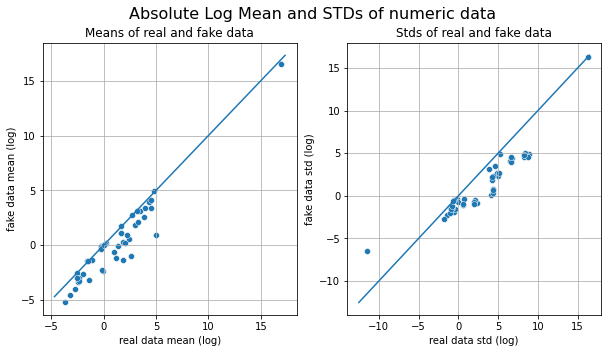

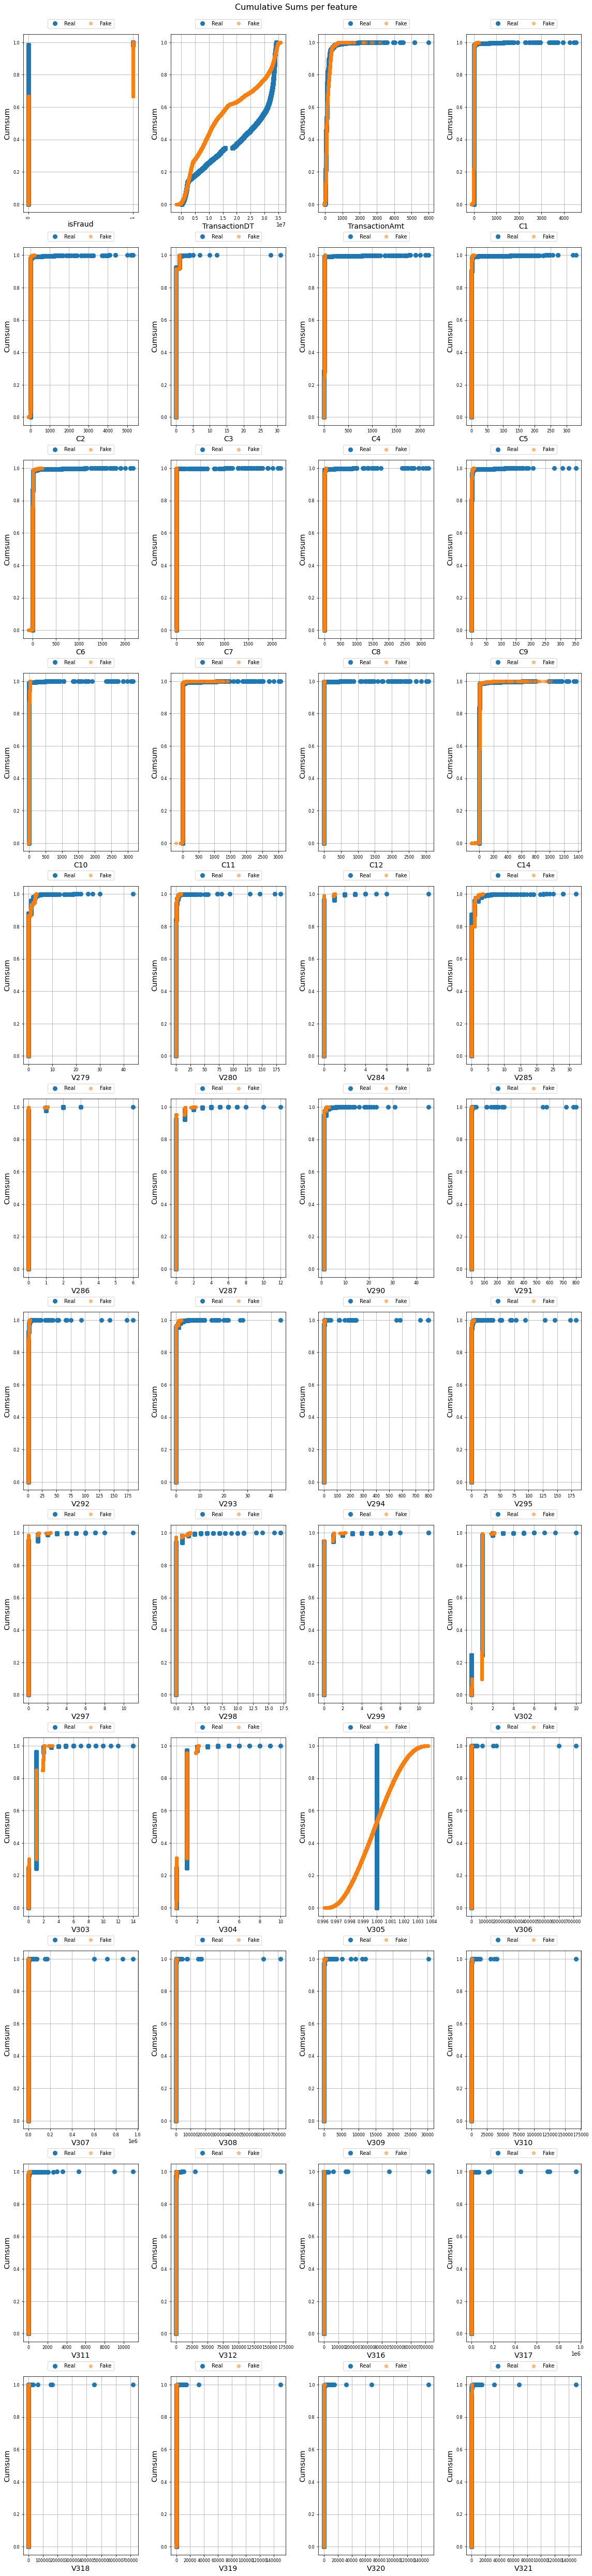

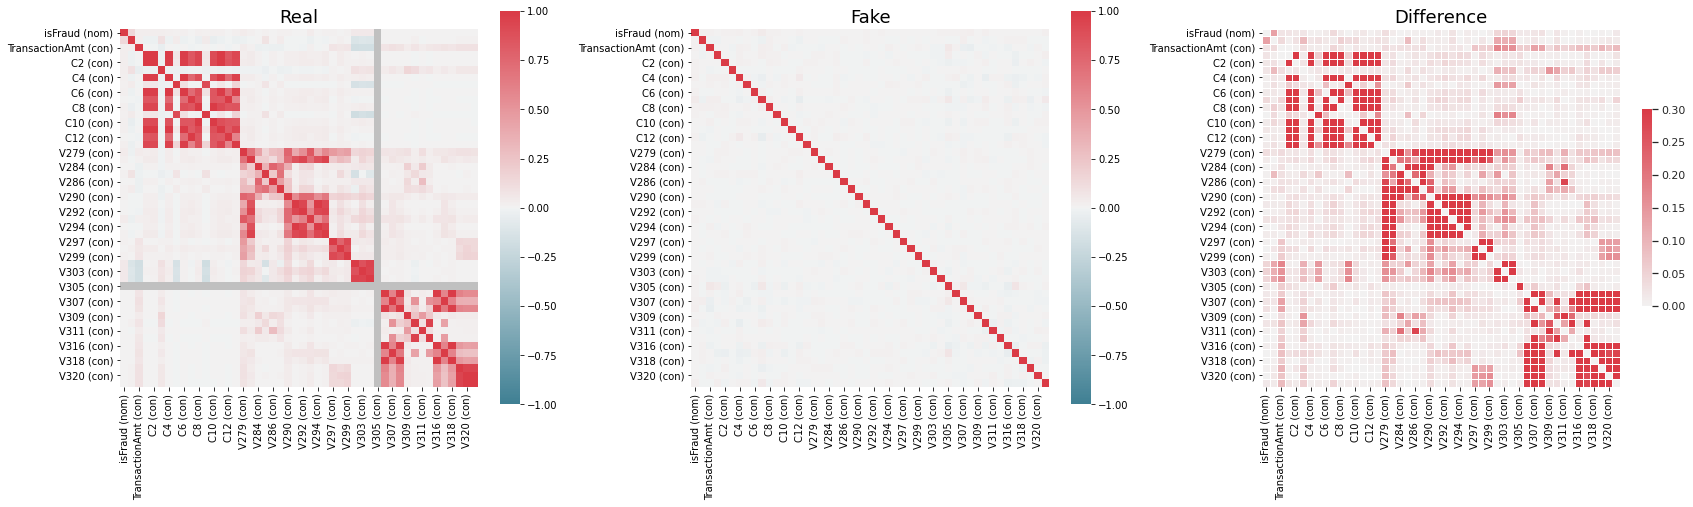

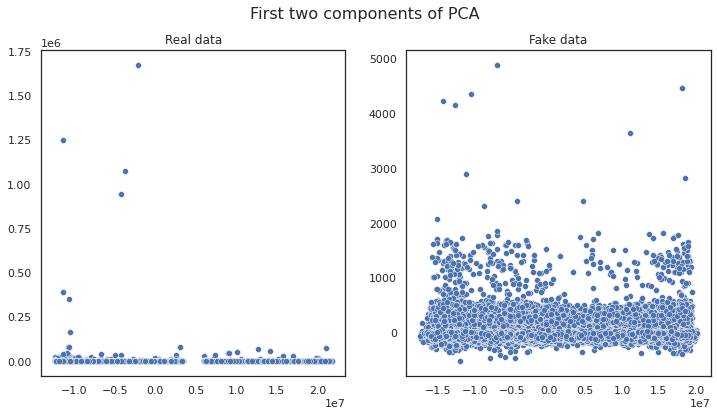

In [12]:
tab_eval.visual_evaluation()

### Random Tabular Data

In the cell below a comparison is done using a uniform random generator.

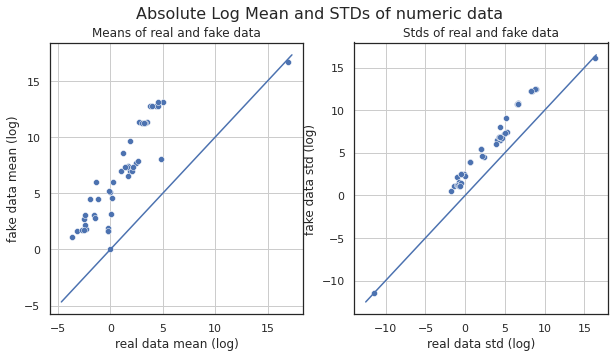

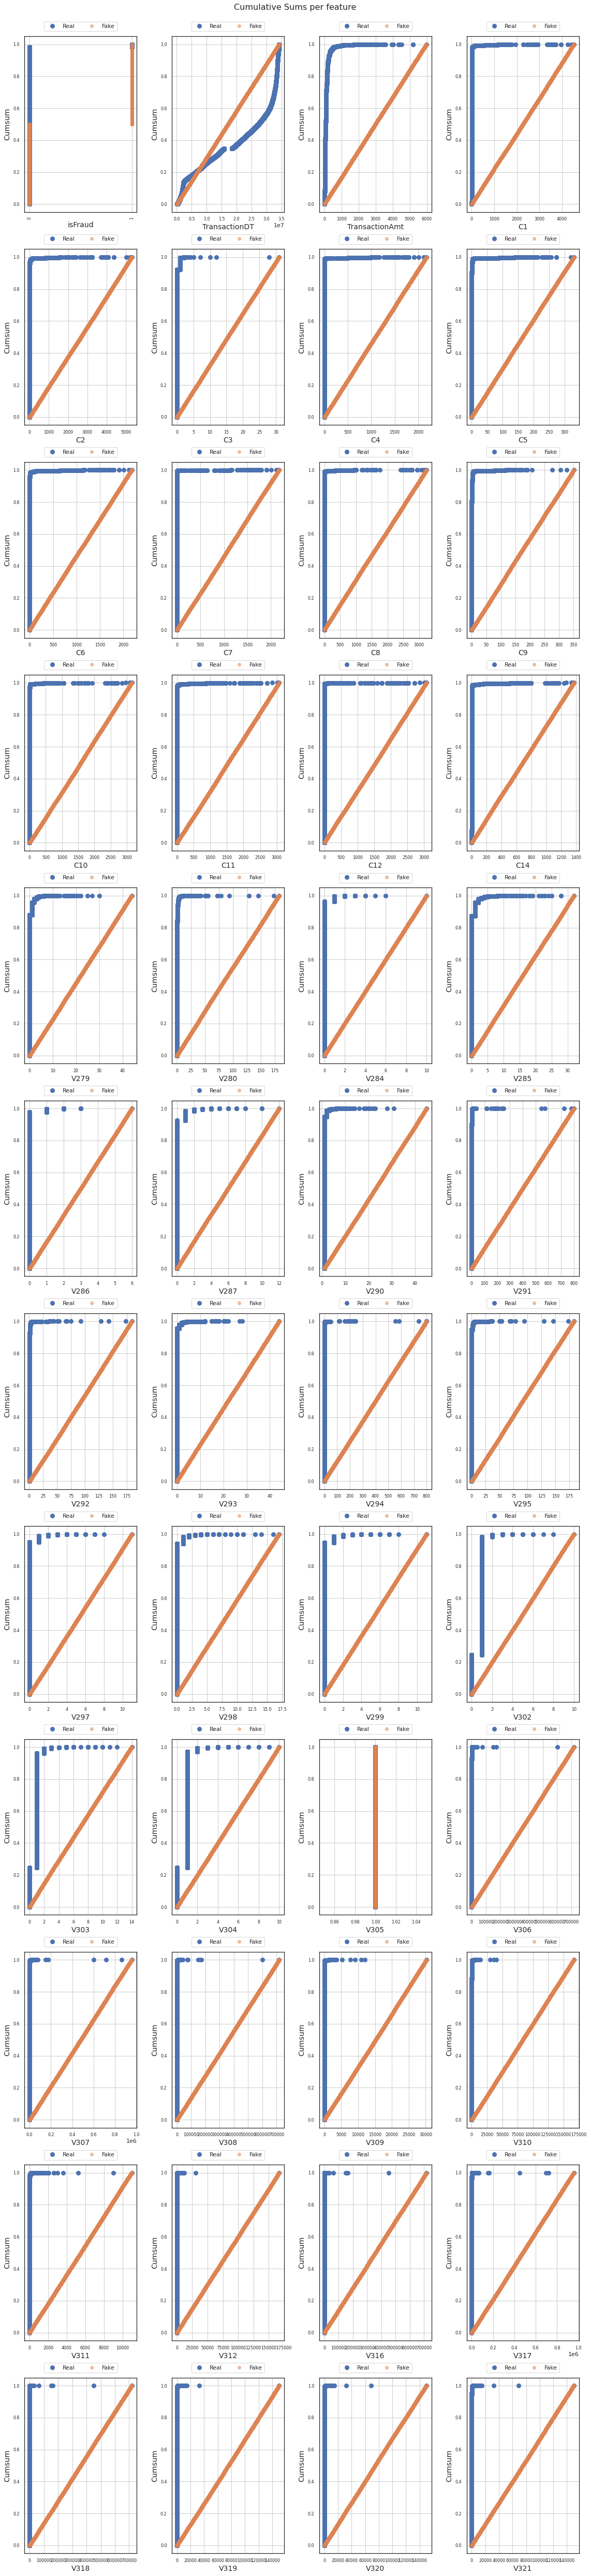

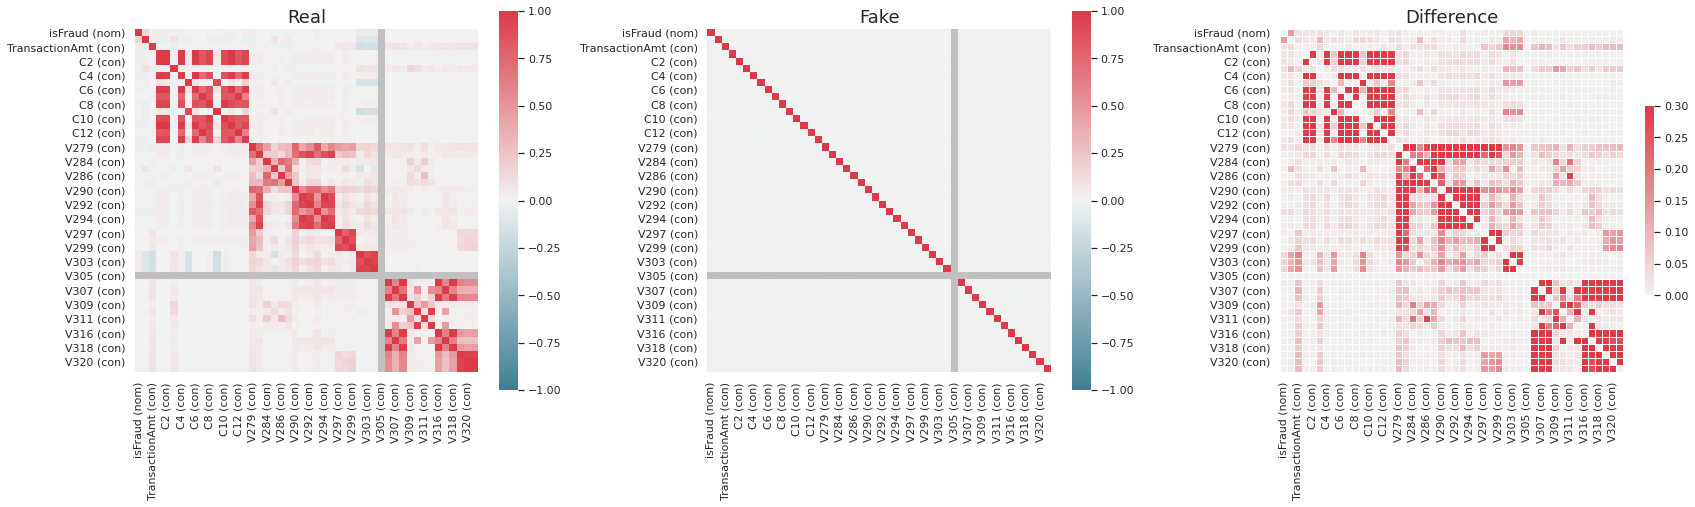

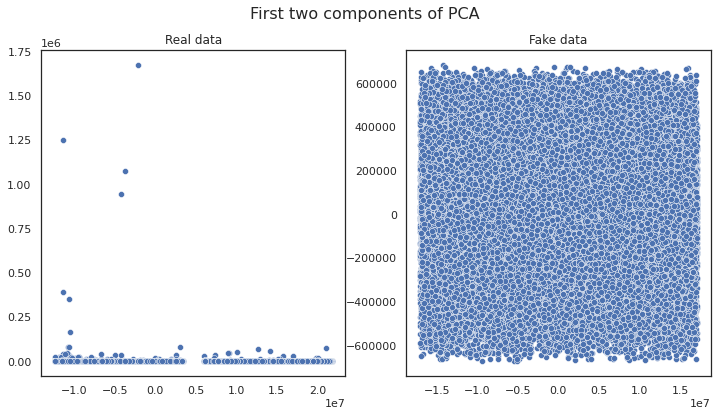

In [13]:
uniform_generator = UniformGenerator()
uniform_generator.fit(real, categorical_columns=cat_cols)

synthetic = uniform_generator.sample(len(real))

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

tab_eval.visual_evaluation()

### Random Multivariate

In the cell below a comparison is done using a multivariate random generator.

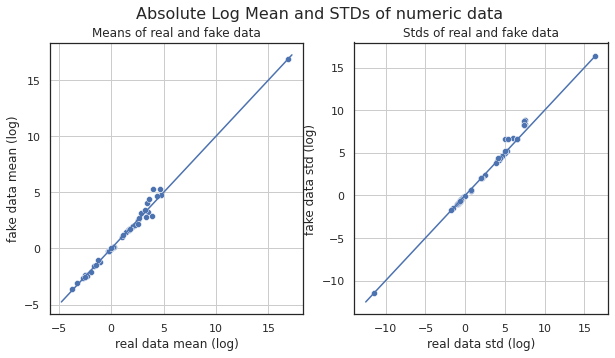

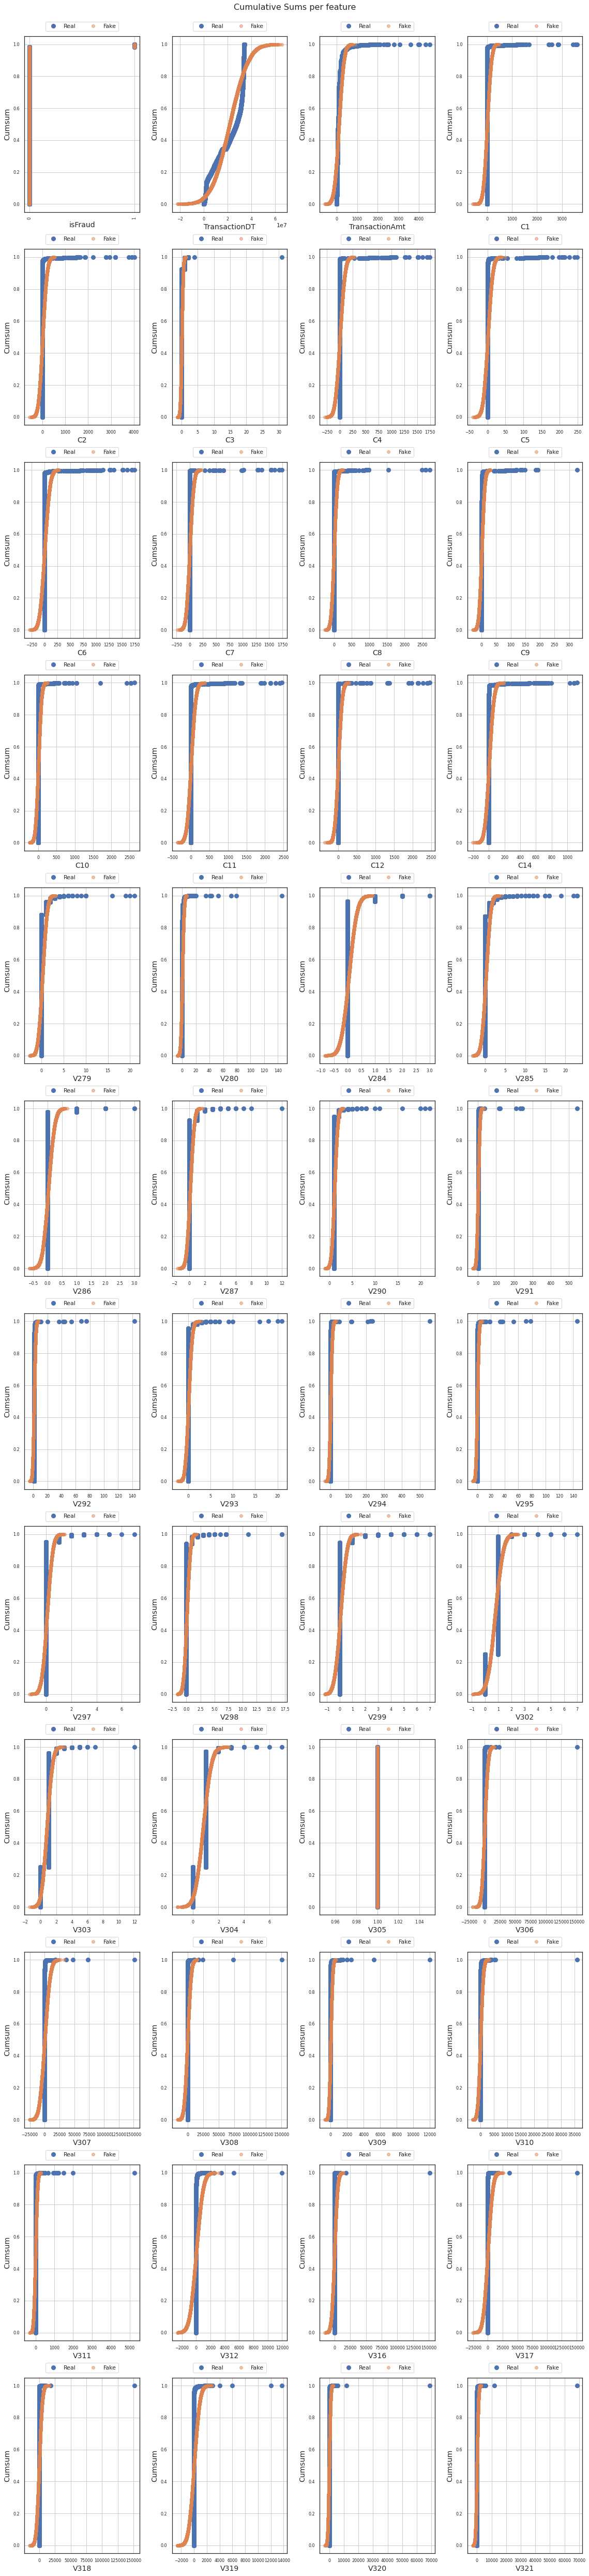

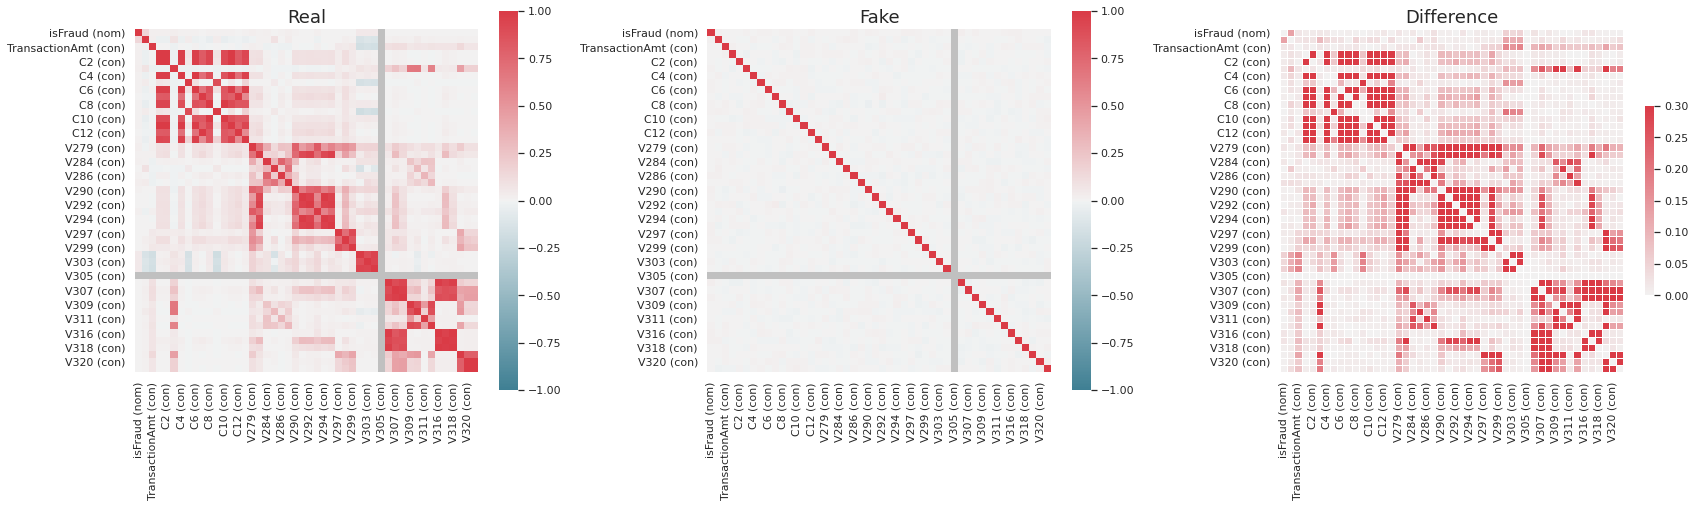

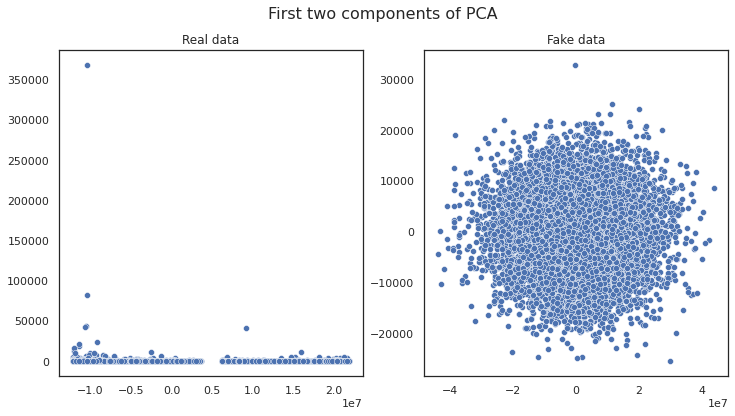

In [14]:
gaussian_generator = GaussianGenerator()
gaussian_generator.fit(real, categorical_columns=cat_cols)

synthetic = gaussian_generator.sample(10000)

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

tab_eval.visual_evaluation()

<a id="4"></a>
## Structure evaluation

Next the graph structure portion can similarly be analyzed.

In the following cells the properly generated graph (using the synthesizer), a random graph, as well as the original are compared.

The tool implements a graph analyzer, i.e. `AnalysisModule`, which provides a series of useful metrics to compare graphs across.

First purely the graph structure is extracted, i.e. nodes and edges.

In [15]:
# - generate a random graph
static_graph_generator._fit_src_dst_results = (0.25, 0.25, 0.25, 0.25)
static_graph_generator._fit_dst_src_results = None
data_random = static_graph_generator.generate(num_nodes_src_set, num_nodes_dst_set, num_edges_src_dst, num_edges_dst_src, is_directed=False, noise=0.0).astype(int)
data_random = list(zip(data_random[:, 0], data_random[:, 1]))

In [16]:
# - extract structure from tabular data
data_proper = data_proper['edge_data']
table_df = data['edge_data']
src_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.SRC_NAME]
dst_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.DST_NAME]
src_ids = table_df[src_name]
dst_ids = table_df[dst_name]
src_dst = list(zip(src_ids, dst_ids))
dst_src = list(zip(dst_ids, src_ids))
graph = list(set(src_dst + dst_src))

In [17]:
print(f'src_dst:{len(src_dst)}')
print(f'dst_srct:{len(dst_src)}')
print(f'graph:{len(graph)}')

src_dst:52008
dst_srct:52008
graph:104016


In [18]:
graph_structure_proper = list(zip(data_proper[src_name], data_proper[dst_name]))
graph_structure_random = data_random
graph_structure_orig = graph

In [19]:
# save graph structure to file
np.savetxt('/workspace/data/ieee_e2e_demo_proper.txt', np.array(graph_structure_proper), fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_e2e_demo_random.txt', np.array(graph_structure_random), fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_e2e_demo_orig.txt', np.array(graph_structure_orig), fmt='%i', delimiter='\t')

In [20]:
graph_analyser = AnalysisModule()

Graph objects are then instantiated using the extracted graph structures

In [21]:
proper_graph = Graph('/workspace/data/ieee_e2e_demo_proper.txt', name='properly_generated', load_eagerly=True, is_directed=False)
random_graph = Graph('/workspace/data/ieee_e2e_demo_random.txt', name='randomly_generated', load_eagerly=True, is_directed=False)
orig_graph = Graph('/workspace/data/ieee_e2e_demo_orig.txt', name='original', load_eagerly=True, is_directed=False)
all_graphs = [proper_graph, random_graph, orig_graph]

The graphs can then be fed to various metrics, for example `get_dd_similarity_score` provides a score between 0 and 1,
comparing the degree distribution of a source graph and destination graph.

In [22]:
orig_proper = get_dd_simmilarity_score(graph_structure_orig, graph_structure_proper, cdf_points=1000)
orig_random = get_dd_simmilarity_score(graph_structure_orig, graph_structure_random, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.9605742491919305
ORIG vs RANDOM: 0.9587495059634821


The `compare_graph_stats` compares the graphs across a series of statistics

In [23]:
df = graph_analyser.compare_graph_stats(*all_graphs, fast=True, path_stats=False, timer=True)
df

Category "Global stats" took 0.27s
Category "Connectivity" took 0.01s
Category "Transitivity" took 0.21s


,Category,Statistic,properly_generated,randomly_generated,original
0,Global stats,Nodes,14210,23612,17289
1,Global stats,Edges,52008,52008,52008
2,Global stats,Density,0.0005,0.0002,0.0003
3,Global stats,Average degree,3.66,2.2,3.01
4,Global stats,Zero deg nodes,0,0,0
5,Global stats,Zero in deg nodes,0,0,0
6,Global stats,Zero out deg nodes,0,0,0
7,Global stats,Self loops,0,0,0
8,Global stats,Bidirectional edges,52008,52008,52008
9,Global stats,Unique undirected edges,52008,52008,52008


"Degree distribution" took 0.02s
"Hop plot" took 1.92s


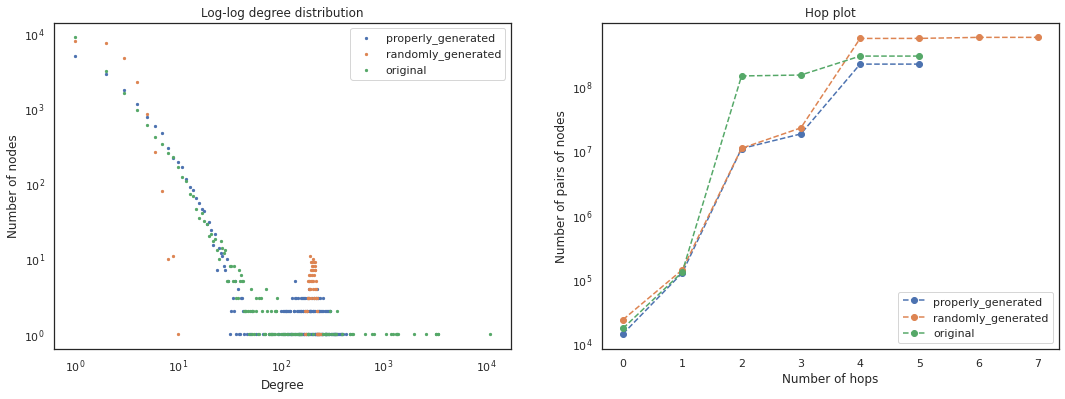

In [24]:
_ = graph_analyser.compare_graph_plots(*all_graphs, timer=True);

# Structure + Feature Distribution

The final graph with its associated features can be compared using a heat map visualization of the associated degree distribution and feature distribution.

In the cells below, the real graph is compared with graphs generated using random generators versus the properly fitted generators.

### Real Data

`plot_node_degree_centrality_feat_dist` consumes a graph and plots the degree distribution-feature distribution for a particular column of interest.

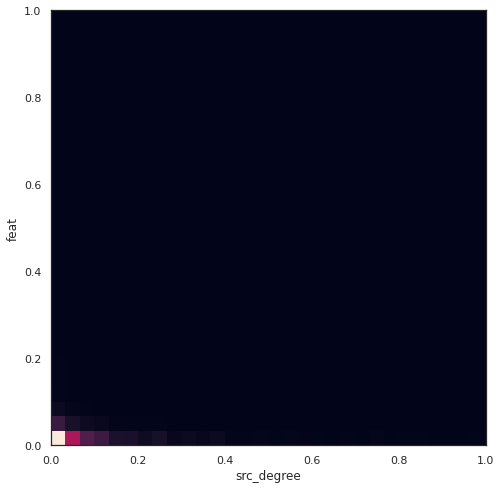

In [25]:
real = data[MetaData.EDGE_DATA]

columns = ['TransactionAmt']
col_info = {}

for col in columns:
    col_info[col] = {'type': ColumnType.CONTINUOUS, 'min': real[col].min(), 'max': real[col].max()}

fig = plot_node_degree_centrality_feat_dist(real, 
                                     col_info, 
                                     src_col='user_id', 
                                     dst_col='product_id')

### Random

In [26]:
src_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.SRC_NAME]
dst_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.DST_NAME]
proper_structure = data_proper[[src_name, dst_name]]

In [27]:
tabular_generator=GaussianGenerator()
graph_aligner=RandomAligner()

In [28]:
tabular_generator.fit(real, categorical_columns=preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.CATEGORICAL_COLUMNS])
synthetic_tabular = tabular_generator.sample(len(proper_structure))
graph_aligner.fit(data, src_col='user_id', dst_col='product_id')
random_data = graph_aligner.align(
    {MetaData.EDGE_DATA: synthetic_tabular, MetaData.EDGE_LIST: proper_structure}, 
    src_name, dst_name)

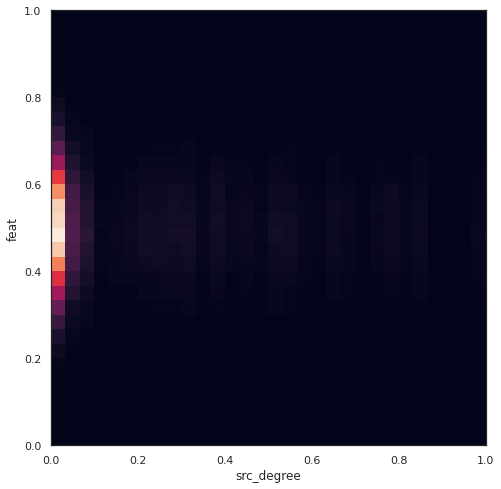

In [29]:
fig = plot_node_degree_centrality_feat_dist(random_data[MetaData.EDGE_DATA], 
                               col_info, 
                               src_col=src_name, 
                               dst_col=dst_name)

### Properly Generated

As depicted below, properly generated graph has the closest resemblines to the 2d heatmap of the original graph.

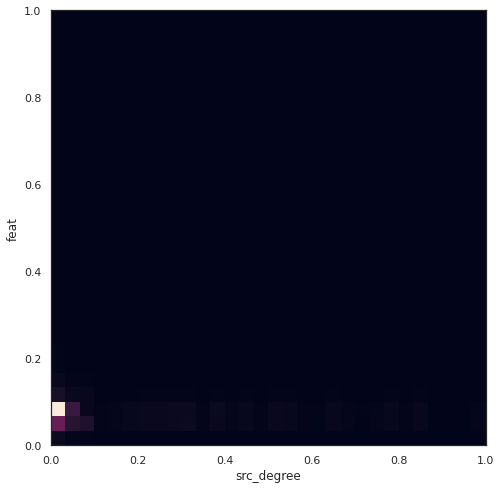

In [30]:
fig = plot_node_degree_centrality_feat_dist(data_proper, 
                               col_info, 
                               src_col=src_name, 
                               dst_col=dst_name)